In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sympy
from sympy import symbols
from sympy.physics.vector import dynamicsymbols
from sympy.physics.mechanics import LagrangesMethod

In [2]:
# --- 1) Define symbols and functions ---
t = sympy.Symbol('t', real=True)
m1, m2 = symbols('m1 m2', positive=True)  # Masses

# Generalized coordinates: x1(t), x2(t)
x1, x2 = dynamicsymbols('x1 x2', real=True)

# Generalized velocities: dx1(t)/dt, dx2(t)/dt
x1_dot, x2_dot = dynamicsymbols('x1 x2', 1, real=True)

# --- 2) Define Kinetic and Potential Energies ---
T = 0.5*m1*x1_dot**2 + 0.5*m2*x2_dot**2

# For collision modeling, we can use a stiff repulsive potential
# This gives a strong repulsive force when particles get close
# n controls stiffness (higher = stiffer collision)
V = 1 / sympy.Abs(x2 - x1)

L = T - V  # Lagrangian

# --- 3) Form the Lagrange Equations ---
LM = LagrangesMethod(L, [x1, x2])
euler_lagrange_eq = LM.form_lagranges_equations()
euler_lagrange_eq.simplify()
euler_lagrange_eq # Euler-Lagrange equations for the system - these equal zero

Matrix([
[Piecewise((1.0*m1*Derivative(x1(t), (t, 2)), Eq(x1(t) - x2(t), 0)), ((1.0*m1*(x1(t) - x2(t))**2*Abs(x1(t) - x2(t))*Derivative(x1(t), (t, 2)) - x1(t) + x2(t))/((x1(t) - x2(t))**2*Abs(x1(t) - x2(t))), True))],
[Piecewise((1.0*m2*Derivative(x2(t), (t, 2)), Eq(x1(t) - x2(t), 0)), ((1.0*m2*(x1(t) - x2(t))**2*Abs(x1(t) - x2(t))*Derivative(x2(t), (t, 2)) + x1(t) - x2(t))/((x1(t) - x2(t))**2*Abs(x1(t) - x2(t))), True))]])

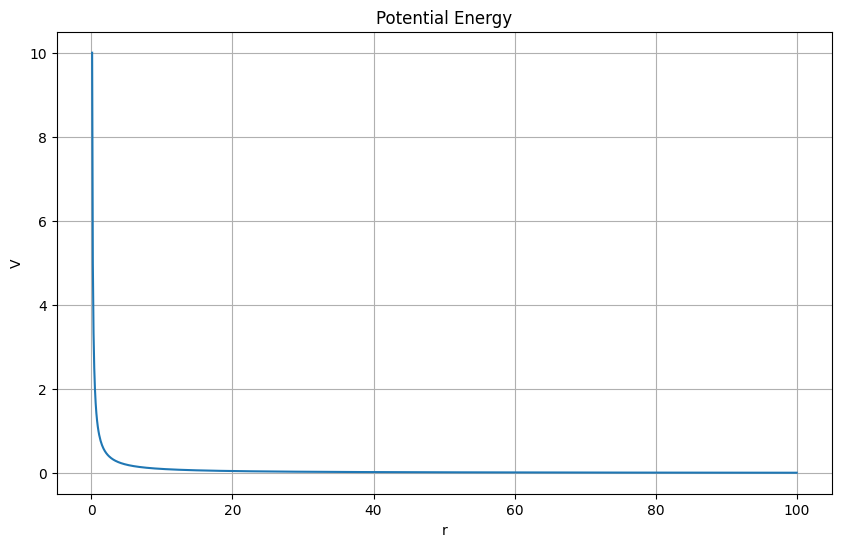

In [3]:
r_eval = np.linspace(0.1, 100, 1000)
V_fun = sympy.lambdify([x1, x2], V, modules="numpy")
pd.Series(V_fun(0, r_eval), index=r_eval).plot(figsize=(10, 6), xlabel='r', ylabel='V', title='Potential Energy', grid=True);

In [4]:
# LM.rhs() calculates and returns a matrix representing the equations of motion - this is the derivative of [x1, x2, d_x1, d_x2]
# The printed matrix is structured as follows:
#   • Row 1: Derivative of x1(t), i.e., the velocity of mass 1.
#   • Row 2: Derivative of x2(t), i.e., the velocity of mass 2.
#   • Row 3: The acceleration equation for mass 1 (derived from the force divided by m1).
#   • Row 4: The acceleration equation for mass 2 (derived from the force divided by m2).
eom = LM.rhs()
eom.simplify()
eom

Matrix([
[                                                                      Derivative(x1(t), t)],
[                                                                      Derivative(x2(t), t)],
[ Piecewise((0, Eq(x1(t) - x2(t), 0)), (1.0/(m1*(x1(t) - x2(t))*Abs(x1(t) - x2(t))), True))],
[Piecewise((0, Eq(x1(t) - x2(t), 0)), (-1.0/(m2*(x1(t) - x2(t))*Abs(x1(t) - x2(t))), True))]])

In [5]:
constants = {m1: 1.0, m2: 1.0}
eom_with_constants = eom.subs(constants)
eom_with_constants

Matrix([
[                                                                   Derivative(x1(t), t)],
[                                                                   Derivative(x2(t), t)],
[ Piecewise((0, Eq(x1(t) - x2(t), 0)), (1.0/((x1(t) - x2(t))*Abs(x1(t) - x2(t))), True))],
[Piecewise((0, Eq(x1(t) - x2(t), 0)), (-1.0/((x1(t) - x2(t))*Abs(x1(t) - x2(t))), True))]])

In [6]:
# Define state vector - this is what evolves over time
state_symbols = [x1, x2, x1_dot, x2_dot]

# Convert symbolic function to a numerical function
eom_num = sympy.lambdify(state_symbols, eom_with_constants, modules="numpy")

# Define first-order ODEs as needed by solve_ivp
def system(t, y):
  return eom_num(*y).flatten()

# Set initial conditions
x1_0 = -125.0  # initial position of mass 1
x2_0 =  0.0  # initial position of mass 2
v1_0 =  1.  # initial velocity of mass 1
v2_0 =  0.  # initial velocity of mass 2

y0 = [x1_0, x2_0, v1_0, v2_0] # Entire inital state

t_max = 250

# Set time points
t_eval = np.linspace(0, t_max, 1000)

# Solve the ODE system
from scipy.integrate import solve_ivp
sol = solve_ivp(system, [0, t_max], y0, t_eval=t_eval)

solution = pd.DataFrame(sol.y.T, columns=['x1', 'x2', 'v1', 'v2'], index=sol.t)

solution

,x1,x2,v1,v2
0.000000,-125.000000,0.000000,1.000000,0.000000
0.250250,-124.749752,0.000002,0.999984,0.000016
0.500501,-124.499508,0.000008,0.999968,0.000032
0.750751,-124.249267,0.000018,0.999952,0.000048
1.001001,-123.999031,0.000032,0.999935,0.000065
...,...,...,...,...
248.998999,5.241097,118.757902,-0.000467,1.000467
249.249249,5.240979,119.008271,-0.000487,1.000487
249.499499,5.240855,119.258645,-0.000506,1.000506
249.749750,5.240726,119.509024,-0.000525,1.000525


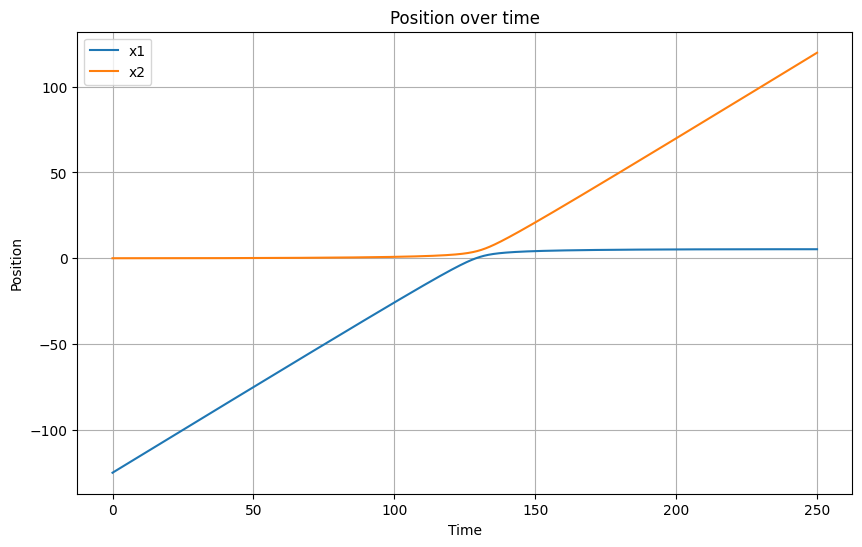

In [7]:
solution[["x1", "x2"]].plot(figsize=(10, 6), xlabel='Time', ylabel='Position', title='Position over time', grid=True);

<Axes: title={'center': 'Velocity over time'}, xlabel='Time', ylabel='Velocity'>

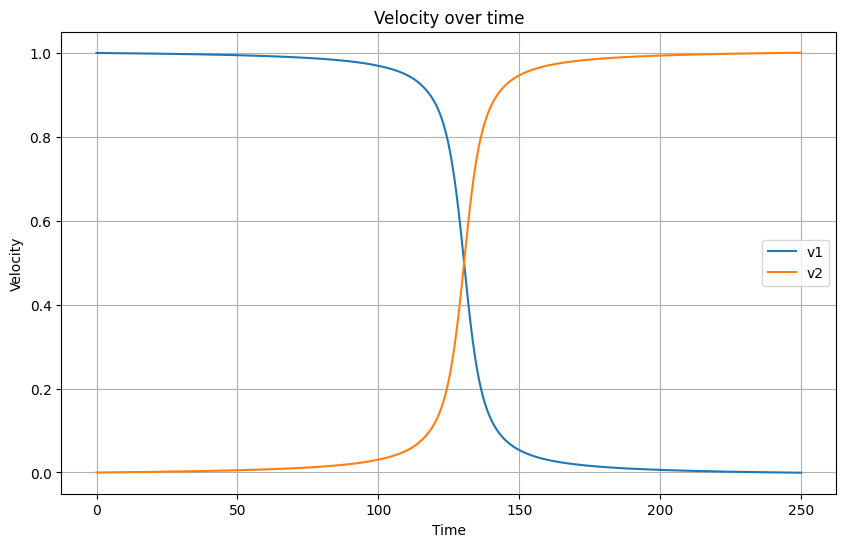

In [8]:
solution[["v1", "v2"]].plot(figsize=(10, 6), xlabel='Time', ylabel='Velocity', title='Velocity over time', grid=True)